# MicroTask 1

### Produce a listing of the number of new committers per month, and the number of commits for each of them, as a table and as a CSV file. Use the GrimoireLab enriched index for git.

In [173]:
#Importing Libraries 
from datetime import datetime
import elasticsearch
import elasticsearch_dsl
from pprint import pprint
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from pandas.tools.plotting import table


In [174]:
# Url for the git repo to analyze
repo_url = 'http://github.com/grimoirelab/perceval.git'

# ElasticSearch instance (url)
# Assuming your localhost instance is ON , if not initialize it
es = elasticsearch.Elasticsearch('http://localhost:9200/',  verify_certs=False)

enrich_index_name = 'git'
raw_index_name = 'git_raw'


### Deleting any previous instance of the index ( if they exist )

In [135]:
if(es.indices.exists(enrich_index_name)):
    es.indices.delete(enrich_index_name)
    
if(es.indices.exists(raw_index_name)):
    es.indices.delete(raw_index_name)    

In [175]:
#Creating and uploading indexes in ELasticSearch 

subprocess.run(['p2o.py', '--enrich', '--index', raw_index_name , '--index-enrich', enrich_index_name, 
 '-e','http://localhost:9200/', '--no_inc', '--debug', 'git', repo_url ])

#You can also upload the data by running the command "p2o.py --enrich --index git_raw --index-enrich git \
#-e http://localhost:9200 --no_inc --debug   git https://github.com/grimoirelab/perceval.git" on terminal



CompletedProcess(args=['p2o.py', '--enrich', '--index', 'git_raw', '--index-enrich', 'git', '-e', 'http://localhost:9200/', '--no_inc', '--debug', 'git', 'http://github.com/grimoirelab/perceval.git'], returncode=1)

In [176]:
#Extracting the information from the index we uploaded on Elastic Search

response = es.search(index=enrich_index_name)
Number_of_commits = response['hits']['total']
response = es.search( index=enrich_index_name , body={"size":Number_of_commits} )
print("Total Number of commits :- %s" %(Number_of_commits))


Total Number of commits :- 1136


In [177]:
author=[] #declaring a list
output = set() # set funtion in python chooses unique strings

for i in response['hits']['hits']:
    output.add(i['_source']['author_name']) #will add only unique author name strings to the list

for i in output:
    dictionary = {'Author_Name' : i , 'First_Commit_Date' : 'NA' , 'Total_Number_of_commits' : 0}
    author.append(dictionary)
    
# for i in author:
#     pprint(i)
# author


In [178]:
for i in response['hits']['hits']:
    # print(author['Author_Name'])
    for j in author:
        if j['Author_Name'] == i['_source']['author_name'] :
            
            
    
            if j['First_Commit_Date'] == "NA":
                temp = i['_source']['author_date']
                

                #can also do the same the same through this method
                # temp = i['_source']['author_date'].split('T')
                # print(temp[0])

                j['First_Commit_Date'] = datetime.strptime(temp, '%Y-%m-%dT%H:%M:%S').strftime('%Y-%m')
            j['Total_Number_of_commits']=j['Total_Number_of_commits']+1

# author


First-Commit-Date :- 2015-11 
Last-Commit-Date  :- 2018-03


,Author_Name,First_Commit_Date,Total_Number_of_commits
1,Santiago Dueñas,2015-11,731
2,Alvaro del Castillo,2015-12,47
3,Jesus M. Gonzalez-Barahona,2016-01,18
4,Alberto Martín,2016-02,51
5,camillem,2016-03,2
6,J. Manrique Lopez de la Fuente,2016-03,1
7,quan,2016-05,5
8,Luis Cañas Díaz,2016-09,1
9,Stephan Barth,2017-01,1
10,Valerio Cosentino,2017-09,263


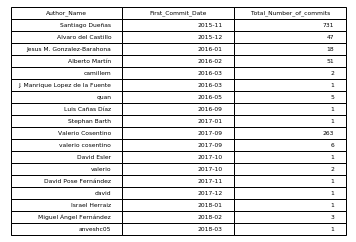

In [183]:
s = pd.DataFrame(author)
# s['First_Commit_Date'] = pd.to_datetime(s.First_Commit_Date)
s.sort_values(by = 'First_Commit_Date' , inplace=True)
s.index = range(1,len(s.index)+1)
# pprint(len(s.index))
# pprint(s.First_Commit_Date[len(s.index)])
temp1 = s.First_Commit_Date[1] #stores the first ever commit made on the repo
temp2 = s.First_Commit_Date[len(s.index)] #stores the latest commit made on the repo
print("First-Commit-Date :- %s \nLast-Commit-Date  :- %s" %(temp1,temp2)) # printing the first and last commit date on the repo


s.to_csv('author_number_of_commits.csv')

#https://stackoverflow.com/questions/35634238/how-to-save-a-pandas-dataframe-table-as-a-png

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, s,rowLabels=['']*s.shape[0], loc='center')
plt.savefig('author_number_of_commits.png' , bbox_inches = 'tight')
s

In [180]:
#https://stackoverflow.com/questions/46741423/add-months-to-a-date-in-pandas
#Above link on how to add the last month to a date
month_commit = pd.date_range(*(pd.to_datetime([temp1, temp2]) + pd.offsets.MonthEnd()), freq='M')
# pprint(month_commit)
month_commit = [i.strftime('%Y-%m') for i in month_commit]
# pprint(month_commit)

commiters_per_month = dict() #or commiters_per_month = [] #will check the number of "new author commits" occured during each month
temp = []
for i in month_commit:
    commiters_per_month[i]=0
# pprint(commiters_per_month)

for i in author:
    commiters_per_month[i['First_Commit_Date']]+=1

# pprint(commiters_per_month)    

In [181]:
#pd.DataFrame(commiters_per_month.items()) in python version < 3 . Check the below link for for more details
#https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe
answer = pd.DataFrame(list(commiters_per_month.items()), columns=['year-month' , 'Number_of_Commits'])
answer.sort_values(by = 'year-month' , inplace=True)
answer.index = range(1,len(answer.index)+1)
# print(answer)


,year-month,Number_of_Commits
1,2015-11,1
2,2015-12,1
3,2016-01,1
4,2016-02,1
5,2016-03,2
6,2016-04,0
7,2016-05,1
8,2016-06,0
9,2016-07,0
10,2016-08,0


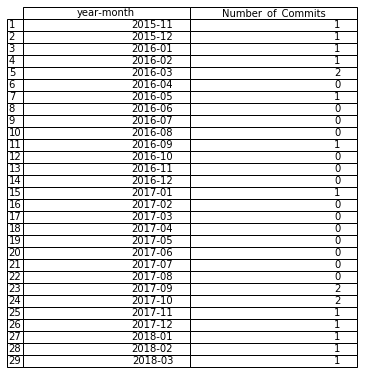

In [184]:
answer.to_csv('authors_per_month.csv')

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis


table(ax,answer , loc='center' )
plt.savefig('authors_per_month.png' , bbox_inches = 'tight' )
answer